In [1]:
!pip install category_encoders
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from category_encoders import CatBoostEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [3]:
encounters_df = pd.read_csv("encounter_patient_info_v3.csv")

encounters_df.columns = encounters_df.columns.str.replace('"', "").str.strip()

encounters_df['TOTAL_MEDICATIONS_BASE_COST'] = encounters_df['TOTAL_MEDICATIONS_BASE_COST'].fillna(0)

"""
I ran all of this without the target being capped and the models have a R-squared of around 0.41 but capping the
values using the IQR method resulted in a much greater accuracy. This took away to much data as using the IQR method
capped the target at 1 hour only which is way to small so i increased it to cover the 0.99 quantile of the data which
will be capping at 50 hours. There are no data points at exactly 50 hours so our data being capped at 50 hours can be
defined to be understood as above 50 hours. I later get into possibly splitting our enconter durations into class duration
later in this notebook if you want to take a look at that.
"""
# compute the target cap to handle very extreme outliers
cap = encounters_df['DURATION_HOURS'].clip(upper = 50)

# create a capped target
encounters_df['DURATION_CAP'] = encounters_df['DURATION_HOURS'].clip(upper=cap)

X = encounters_df.drop(columns=['DURATION_HOURS', 'Id', 'START', 'PATIENTID', 'DURATION_CAP'])
y = encounters_df['DURATION_CAP']


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

# using CatBoostEncoder to encode our high-cardinality categorical features
# what it does: Encodes categorical features as smoothed, out-of-fold target means (no leakage; rare/unseen levels => global mean)
encoder = CatBoostEncoder(cols=X_train.select_dtypes(include=['object','bool']).columns, random_state=42)

X_train_enc = encoder.fit_transform(X_train, y_train)
X_val_enc   = encoder.transform(X_val)
X_test_enc  = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_val_scaled   = scaler.transform(X_val_enc)
X_test_scaled  = scaler.transform(X_test_enc)

encounters_df.describe()

encounters_df.head()


,Id,DURATION_HOURS,START,PATIENTID,GENDER,PATIENT_AGE_AT_ENCOUNTER,HAD_ALLERGY,BASE_ENCOUNTER_COST,ORGNAME,ORGTRAFFIC,...,PATIENT_MEDICATION_COUNT,TOTAL_MEDICATIONS_BASE_COST,PATIENT_IMMUNIZATION_COUNT,PREVIOUS_PROCEDURE_COUNT,HAD_IMAGING,START_HOUR,START_WEEKDAY,START_MONTH,IS_HOLIDAY,DURATION_CAP
0,000186d2-1316-4b58-be65-272233953fcb,1.50,2014-12-03 13:12:11+00:00,8be62b06-5994-47fe-aad8-a27a02e054fa,F,27.0,False,129.16,MORTON HOSPITAL,1682,...,0,0.0000,4,95,False,13,2,12,0,1.50
1,0002adbb-59c3-494a-bb17-0d1acc692ae8,0.85,2014-12-06 12:52:02+00:00,1e52e4fe-13c7-41ad-8b3e-5933fdd553c4,F,16.0,False,129.16,COOLEY DICKINSON HOSPITAL INC THE,1641,...,2,274.0100,2,55,False,12,5,12,0,0.85
2,0005b0a0-1b05-40ec-a741-11c116654840,0.55,2018-02-20 01:11:43+00:00,ef0e5433-6dab-4608-86e4-5b2fb9647d2d,F,40.0,False,129.16,FALMOUTH HOSPITAL,1728,...,2,1339.8400,2,57,False,1,1,2,0,0.55
3,000c97b3-5832-4ecc-8a47-76c0197fffe4,0.25,2018-11-17 22:09:56+00:00,3dd2dd29-7cd0-48f7-b859-136c6e9d36e0,M,98.0,False,129.16,NEWTON-WELLESLEY HOSPITAL,2658,...,4,2277.1099,2,33,False,22,5,11,0,0.25
4,000c9d31-d256-4308-91a3-cf4181178ba2,0.25,2015-09-04 09:49:43+00:00,b44b3fde-b4bd-46eb-8ced-caccab915738,F,49.0,False,129.16,PCP36993,62,...,1,526.9800,1,5,False,9,4,9,0,0.25


Epoch 01 | Train MSE: 17.7075 | Val MSE: 6.5427
Epoch 02 | Train MSE: 6.5171 | Val MSE: 4.0009
Epoch 03 | Train MSE: 5.5248 | Val MSE: 2.9092
Epoch 04 | Train MSE: 4.8508 | Val MSE: 2.3882
Epoch 05 | Train MSE: 4.4911 | Val MSE: 2.0863
Epoch 06 | Train MSE: 4.3393 | Val MSE: 1.8870
Epoch 07 | Train MSE: 4.1647 | Val MSE: 1.6927
Epoch 08 | Train MSE: 4.2013 | Val MSE: 1.6359
Epoch 09 | Train MSE: 4.1355 | Val MSE: 1.5476
Epoch 10 | Train MSE: 4.0254 | Val MSE: 1.4835
Epoch 11 | Train MSE: 3.9862 | Val MSE: 1.4221
Epoch 12 | Train MSE: 3.8605 | Val MSE: 1.3709
Epoch 13 | Train MSE: 3.8167 | Val MSE: 1.3281
Epoch 14 | Train MSE: 3.8082 | Val MSE: 1.2485
Epoch 15 | Train MSE: 3.7960 | Val MSE: 1.2177
Epoch 16 | Train MSE: 3.7565 | Val MSE: 1.2410
Epoch 17 | Train MSE: 3.6584 | Val MSE: 1.1956
Epoch 18 | Train MSE: 3.6713 | Val MSE: 1.2165
Epoch 19 | Train MSE: 3.5808 | Val MSE: 1.1406
Epoch 20 | Train MSE: 3.6564 | Val MSE: 1.0695
Epoch 21 | Train MSE: 3.7015 | Val MSE: 1.0362
Epoch 22 | T

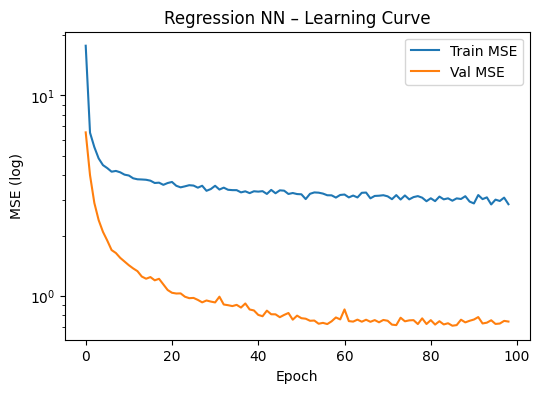

Neural-Net Test RMSE: 1.44 h


In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor   = torch.tensor(y_val.values,   dtype=torch.float32).unsqueeze(1)
y_test_tensor  = torch.tensor(y_test.values,  dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                          batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor,   y_val_tensor),
                          batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor,  y_test_tensor),
                          batch_size=64, shuffle=False)

# feed-forward NN
class NNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, p_drop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train_scaled.shape[1]
nn_model  = NNRegressor(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model.to(device)

# lists to collect metrics for learnign curve
train_mse_hist, val_mse_hist = [], []

# training loop
for epoch in range(1, 100):

    # train
    nn_model.train()
    train_sse = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion(nn_model(xb), yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_sse += loss.item() * xb.size(0)
    train_mse = train_sse / len(train_loader.dataset)
    train_mse_hist.append(train_mse)

    # validate
    nn_model.eval()
    with torch.no_grad():
        val_sse = sum(
            criterion(nn_model(xb.to(device)), yb.to(device)).item() * xb.size(0)
            for xb, yb in val_loader
        )
    val_mse = val_sse / len(val_loader.dataset)
    val_mse_hist.append(val_mse)

    print(f"Epoch {epoch:02d} | Train MSE: {train_mse:.4f} | Val MSE: {val_mse:.4f}")

# learning-curve plot
plt.figure(figsize=(6,4))
plt.plot(train_mse_hist, label="Train MSE")
plt.plot(val_mse_hist,   label="Val MSE")
plt.yscale("log")
plt.xlabel("Epoch");  plt.ylabel("MSE (log)")
plt.title("Regression NN – Learning Curve");  plt.legend();  plt.show()

# test-set RMSE
nn_model.eval()
with torch.no_grad():
    sse = 0.0
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        sse += criterion(nn_model(xb), yb).item() * xb.size(0)

test_rmse = (sse / len(test_loader.dataset)) ** 0.5
print(f"Neural-Net Test RMSE: {test_rmse:.2f} h")

In [ ]:
# NN predictions on each split
def loader_preds(loader):
    nn_model.eval()
    preds_list = []
    with torch.no_grad():
        for xb, _ in loader:
            preds = nn_model(xb.to(device)).cpu().numpy().flatten()
            preds_list.append(preds)
    return np.concatenate(preds_list)

y_train_pred = loader_preds(train_loader)
y_val_pred   = loader_preds(val_loader)
y_test_pred  = loader_preds(test_loader)

train_rmse = mean_squared_error(y_train, y_train_pred)
val_rmse   = mean_squared_error(y_val,   y_val_pred)
test_rmse  = mean_squared_error(y_test,  y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
val_r2   = r2_score(y_val,   y_val_pred)
test_r2  = r2_score(y_test,  y_test_pred)

print("────────── Neural-Net Performance ──────────")
print(f"Val  : RMSE = {val_rmse:.2f}  |  R² = {val_r2:.4f}")
print(f"Test : RMSE = {test_rmse:.2f}  |  R² = {test_r2:.4f}")

────────── Neural-Net Performance ──────────
Val  : RMSE = 0.74  |  R² = 0.9746
Test : RMSE = 2.06  |  R² = 0.9177


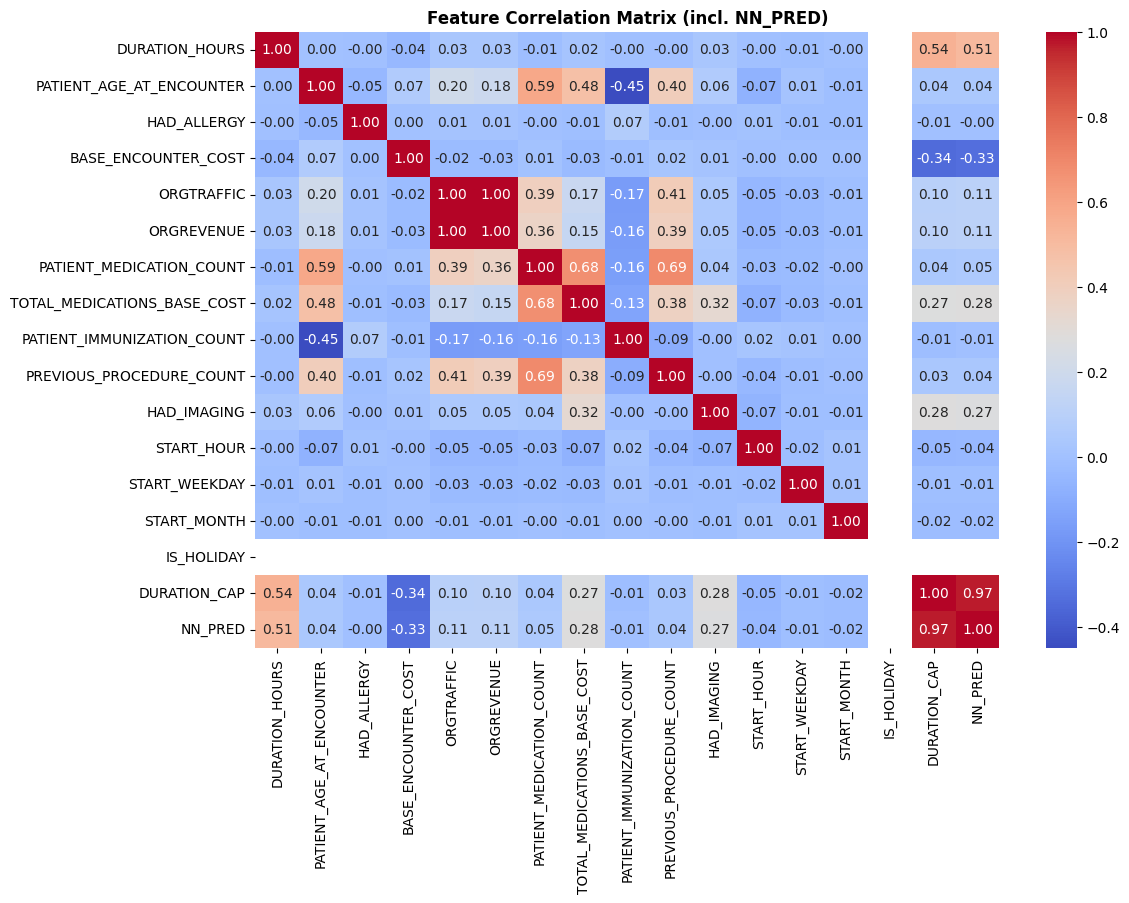

In [ ]:
# encode + scale the full feature set
X_all_std = scaler.transform(
    encoder.transform(
        encounters_df.drop(columns=["DURATION_HOURS","Id","START","PATIENTID","DURATION_CAP"])
    )
)

# predict once for every row
with torch.no_grad():
    encounters_df["NN_PRED"] = (
        nn_model(torch.tensor(X_all_std, dtype=torch.float32, device=device))
        .cpu().numpy()
        .ravel()
    )

# correlation matrix plot
plt.figure(figsize=(12,8))
sns.heatmap(encounters_df.corr(numeric_only=True),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix (incl. NN_PRED)", fontweight="bold")
plt.show()



In [ ]:
# Mean-Absolute-Percentage-Error <--- Do we still want to keep this?
def mape_pct(model, loader, device=device):
    model.eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds  = model(xb)
            total += (preds - yb).abs().div(yb.abs().clamp(min=1e-8)).sum().item()
            n     += yb.numel()
    return 100.0 * total / n

print("── Regression NN: % error (MAPE) ──")
print(f"Train : {mape_pct(nn_model, train_loader):6.2f} %")
print(f"Val   : {mape_pct(nn_model,  val_loader):6.2f} %")
print(f"Test  : {mape_pct(nn_model, test_loader):6.2f} %")


── Regression NN: % error (MAPE) ──
Train :  67.42 %
Val   :  57.81 %
Test  :  70.52 %


In [ ]:
# grab first Linear layer
first_w = nn_model.net[0].weight.detach().cpu().numpy()

# mean absolute weight per feature
abs_mean = np.abs(first_w).mean(axis=0)

# build a DataFrame exactly like the LR version
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "AbsWeight": abs_mean
}).round(4)

# sort by influence (descending)
coef_df = coef_df.reindex(coef_df["AbsWeight"].sort_values(ascending=False).index)

print(coef_df)


                        Feature  AbsWeight
9                ENCOUNTERCLASS     0.4582
10                  DESCRIPTION     0.3181
11            REASONDESCRIPTION     0.2664
1      PATIENT_AGE_AT_ENCOUNTER     0.2531
13  TOTAL_MEDICATIONS_BASE_COST     0.2468
12     PATIENT_MEDICATION_COUNT     0.1657
3           BASE_ENCOUNTER_COST     0.1575
0                        GENDER     0.1424
15     PREVIOUS_PROCEDURE_COUNT     0.1388
4                       ORGNAME     0.1357
5                    ORGTRAFFIC     0.1225
14   PATIENT_IMMUNIZATION_COUNT     0.1052
17                   START_HOUR     0.0988
7                    ORGREVENUE     0.0967
6                 ORGSPECIALITY     0.0928
19                  START_MONTH     0.0880
8                          CITY     0.0769
18                START_WEEKDAY     0.0476
2                   HAD_ALLERGY     0.0000
16                  HAD_IMAGING     0.0000
20                   IS_HOLIDAY     0.0000


Epoch 01 | Train loss 1.067 | Val loss 0.639 | Train acc 0.569 | Val acc 0.581
Epoch 02 | Train loss 0.656 | Val loss 0.513 | Train acc 0.618 | Val acc 0.626
Epoch 03 | Train loss 0.588 | Val loss 0.473 | Train acc 0.637 | Val acc 0.647
Epoch 04 | Train loss 0.550 | Val loss 0.445 | Train acc 0.650 | Val acc 0.657
Epoch 05 | Train loss 0.538 | Val loss 0.427 | Train acc 0.669 | Val acc 0.684
Epoch 06 | Train loss 0.512 | Val loss 0.427 | Train acc 0.684 | Val acc 0.696
Epoch 07 | Train loss 0.495 | Val loss 0.405 | Train acc 0.699 | Val acc 0.710
Epoch 08 | Train loss 0.471 | Val loss 0.401 | Train acc 0.700 | Val acc 0.709
Epoch 09 | Train loss 0.466 | Val loss 0.392 | Train acc 0.720 | Val acc 0.723
Epoch 10 | Train loss 0.461 | Val loss 0.394 | Train acc 0.725 | Val acc 0.729
Epoch 11 | Train loss 0.450 | Val loss 0.383 | Train acc 0.723 | Val acc 0.723
Epoch 12 | Train loss 0.436 | Val loss 0.378 | Train acc 0.723 | Val acc 0.729
Epoch 13 | Train loss 0.434 | Val loss 0.374 | Train

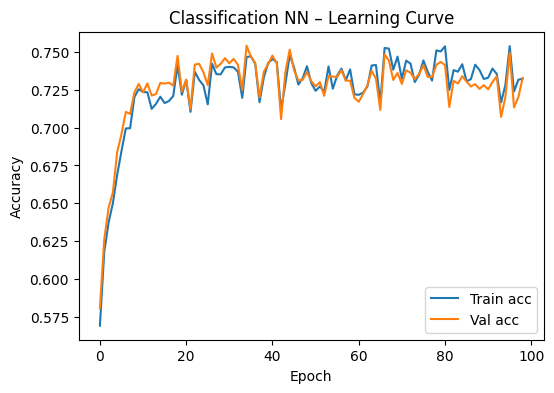

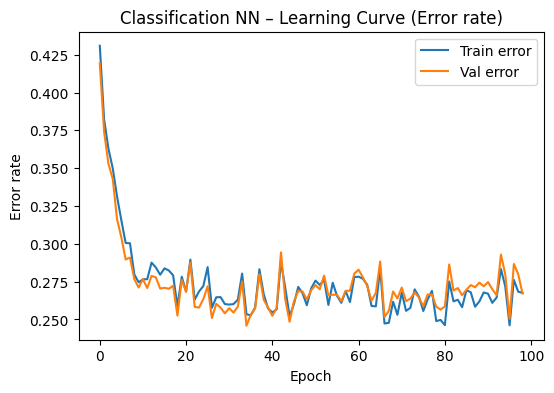

                    precision    recall  f1-score   support

    Quick (≤0.25h)       0.90      0.67      0.77      2858
   Short (0.25–1h]       0.61      0.77      0.68      2228
   Moderate (1–6h]       0.64      0.74      0.69       796
      Long (6–24h]       0.91      0.91      0.91        53
Very Long (24–50h]       0.96      0.97      0.96       153
    Extreme (>50h)       0.76      0.93      0.84        14

          accuracy                           0.73      6102
         macro avg       0.80      0.83      0.81      6102
      weighted avg       0.76      0.73      0.73      6102

[[1920  895   40    0    0    3]
 [ 216 1725  286    0    1    0]
 [   3  207  586    0    0    0]
 [   0    0    0   48    4    1]
 [   0    0    0    5  148    0]
 [   0    0    0    0    1   13]]


In [ ]:
# bin the target
bins   = [-float('inf'), 0.25, 1, 6, 24, 50, float('inf')]
labels = [
    'Quick (≤0.25h)',
    'Short (0.25–1h]',
    'Moderate (1–6h]',
    'Long (6–24h]',
    'Very Long (24–50h]',
    'Extreme (>50h)'
]

encounters_df["ENCOUNTER_LENGTH_CLASS"] = pd.cut(
    encounters_df["DURATION_HOURS"],
    bins=bins, labels=labels,
    right=True, include_lowest=True
)

# train / test / val split & preprocessing
X_cls = encounters_df.drop(
    columns=[
        "DURATION_HOURS", "Id", "START", "PATIENTID",
        "DURATION_CAP", "ENCOUNTER_LENGTH_CLASS"
    ]
)
y_cls = encounters_df["ENCOUNTER_LENGTH_CLASS"]

X_temp, X_test, y_temp, y_test = train_test_split(X_cls, y_cls, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

encoder_cls = CatBoostEncoder(cols=X_train.select_dtypes(include=['object','bool']).columns, random_state=42)
X_train_enc = encoder_cls.fit_transform(X_train, y_train)
X_val_enc   = encoder_cls.transform(X_val)
X_test_enc  = encoder_cls.transform(X_test)

scaler_cls = StandardScaler()
X_train_scaled = scaler_cls.fit_transform(X_train_enc)
X_val_scaled   = scaler_cls.transform(X_val_enc)
X_test_scaled  = scaler_cls.transform(X_test_enc)

# torch tensors & loaders
def to_loader(X_np, y_ser, bs=64, shuffle=False):
    Xt = torch.tensor(X_np, dtype=torch.float32)
    yt = torch.tensor(y_ser.cat.codes.values, dtype=torch.long)   # integer classes
    return DataLoader(TensorDataset(Xt, yt), batch_size=bs, shuffle=shuffle)

train_loader_cls = to_loader(X_train_scaled, y_train, shuffle=True)
val_loader_cls   = to_loader(X_val_scaled,   y_val)
test_loader_cls  = to_loader(X_test_scaled,  y_test)

n_classes = len(labels)
input_dim = X_train_scaled.shape[1]

# simple classifier network (softmax)
class NNClassifier(nn.Module):
    def __init__(self, in_dim, hidden=64, p_drop=0.2, n_out=n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, n_out)
        )
    def forward(self, x):
        return self.net(x)

clf = NNClassifier(input_dim).to(device)

# class weights for imbalance
class_counts = y_train.value_counts().sort_index()
weights = 1.0 / class_counts
class_weights = torch.tensor(weights.values, dtype=torch.float32).to(device)

criterion_cls = nn.CrossEntropyLoss(weight=class_weights)
optim_cls     = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)

# training loop and learning-curve
train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []

for epoch in range(1, 100):

    # train
    clf.train()
    clf.train()
    running_loss = 0.0
    total_samples = 0
    for xb, yb in train_loader_cls:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion_cls(clf(xb), yb)

        optim_cls.zero_grad()
        loss.backward()
        optim_cls.step()

        # accumulate for epoch‐level loss
        running_loss  += loss.item() * yb.size(0)
        total_samples += yb.size(0)

    # compute average training loss
    epoch_train_loss = running_loss / total_samples
    train_loss_hist.append(epoch_train_loss)


    # ----- epoch-level TRAIN accuracy ---------------------------------------
    clf.eval(); corr = tot = 0
    with torch.no_grad():
        for xb, yb in train_loader_cls:
            pred = clf(xb.to(device)).argmax(1).cpu()
            corr += (pred == yb).sum().item();  tot += yb.size(0)
    train_acc = corr / tot
    train_acc_hist.append(train_acc)

    # ----- epoch-level VAL loss ---------------------------------------------
    clf.eval()
    running_val_loss = 0.0
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader_cls:
            xb, yb = xb.to(device), yb.to(device)
            logits = clf(xb)
            loss = criterion_cls(logits, yb)
            running_val_loss += loss.item() * yb.size(0)
            total_val        += yb.size(0)

    epoch_val_loss = running_val_loss / total_val
    val_loss_hist.append(epoch_val_loss)

    # ----- epoch-level VAL accuracy -----------------------------------------
    corr = tot = 0
    with torch.no_grad():
        for xb, yb in val_loader_cls:
            pred = clf(xb.to(device)).argmax(1).cpu()
            corr += (pred == yb).sum().item();  tot += yb.size(0)
    val_acc = corr / tot
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train loss {epoch_train_loss:.3f} | Val loss {epoch_val_loss:.3f} | "
          f"Train acc {train_acc:.3f} | Val acc {val_acc:.3f}")

# plot learning curve accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train acc")
plt.plot(val_acc_hist,   label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Classification NN – Learning Curve"); plt.legend(); plt.show()

# plot learning curve error rate
train_err_hist = [1.0 - acc for acc in train_acc_hist]
val_err_hist   = [1.0 - acc for acc in val_acc_hist]

plt.figure(figsize=(6,4))
plt.plot(train_err_hist, label="Train error")
plt.plot(val_err_hist,   label="Val error")
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.title("Classification NN – Learning Curve (Error rate)")
plt.legend()
plt.show()

# final classification report
from sklearn.metrics import classification_report, confusion_matrix

def loader_preds_cls(loader):
    clf.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = clf(xb).cpu()
            all_pred.append(logits.argmax(1))
            all_true.append(yb)
    return torch.cat(all_true).numpy(), torch.cat(all_pred).numpy()

y_true, y_pred = loader_preds_cls(test_loader_cls)

print(classification_report(
    y_true, y_pred, target_names=labels, zero_division=0
))
print(confusion_matrix(y_true, y_pred))


In [ ]:
# error for classification = mis-classification rate
def err_pct(model, loader, device=device):
    model.eval()
    wrong = tot = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            wrong += (model(xb).argmax(1) != yb).sum().item()
            tot   += yb.size(0)
    return 100.0 * wrong / tot

print("── Classification NN: % error ──")
print(f"Val   : {err_pct(clf,  val_loader_cls):6.2f} %")
print(f"Test  : {err_pct(clf, test_loader_cls):6.2f} %")


── Classification NN: % error ──
Val   :  26.72 %
Test  :  27.24 %


In [ ]:
# first layer weights
first_w = clf.net[0].weight.detach().cpu().numpy()

# mean absolute weight per input feature
abs_mean = np.abs(first_w).mean(axis=0)

# DataFrame
coef_df = (
    pd.DataFrame({
        "Feature": X_train.columns,
        "AbsWeight": abs_mean
    })
    .round(4)
    .reindex(np.argsort(-abs_mean))
)

print(coef_df)

                        Feature  AbsWeight
10                  DESCRIPTION     0.3862
21                      NN_PRED     0.3537
15     PREVIOUS_PROCEDURE_COUNT     0.3276
9                ENCOUNTERCLASS     0.2998
11            REASONDESCRIPTION     0.2898
12     PATIENT_MEDICATION_COUNT     0.2504
1      PATIENT_AGE_AT_ENCOUNTER     0.2407
7                    ORGREVENUE     0.2211
13  TOTAL_MEDICATIONS_BASE_COST     0.1877
5                    ORGTRAFFIC     0.1852
14   PATIENT_IMMUNIZATION_COUNT     0.1835
3           BASE_ENCOUNTER_COST     0.1637
4                       ORGNAME     0.1424
19                  START_MONTH     0.1369
8                          CITY     0.1325
18                START_WEEKDAY     0.1240
0                        GENDER     0.1169
6                 ORGSPECIALITY     0.1093
17                   START_HOUR     0.0937
16                  HAD_IMAGING     0.0000
2                   HAD_ALLERGY     0.0000
20                   IS_HOLIDAY     0.0000


Epoch 01 | Train loss 0.666 | Val loss 0.337 | Train acc 0.787 | Val acc 0.784
Epoch 02 | Train loss 0.421 | Val loss 0.326 | Train acc 0.777 | Val acc 0.775
Epoch 03 | Train loss 0.367 | Val loss 0.317 | Train acc 0.790 | Val acc 0.785
Epoch 04 | Train loss 0.338 | Val loss 0.284 | Train acc 0.794 | Val acc 0.790
Epoch 05 | Train loss 0.316 | Val loss 0.284 | Train acc 0.798 | Val acc 0.792
Epoch 06 | Train loss 0.314 | Val loss 0.273 | Train acc 0.792 | Val acc 0.781
Epoch 07 | Train loss 0.313 | Val loss 0.266 | Train acc 0.800 | Val acc 0.794
Epoch 08 | Train loss 0.290 | Val loss 0.288 | Train acc 0.805 | Val acc 0.800
Epoch 09 | Train loss 0.280 | Val loss 0.265 | Train acc 0.804 | Val acc 0.803
Epoch 10 | Train loss 0.279 | Val loss 0.272 | Train acc 0.803 | Val acc 0.792
Epoch 11 | Train loss 0.266 | Val loss 0.249 | Train acc 0.791 | Val acc 0.786
Epoch 12 | Train loss 0.261 | Val loss 0.262 | Train acc 0.803 | Val acc 0.798
Epoch 13 | Train loss 0.259 | Val loss 0.244 | Train

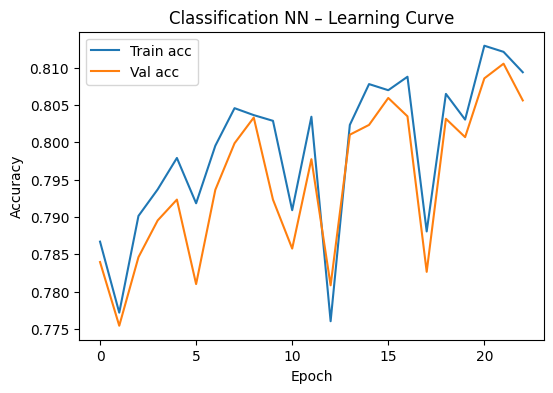

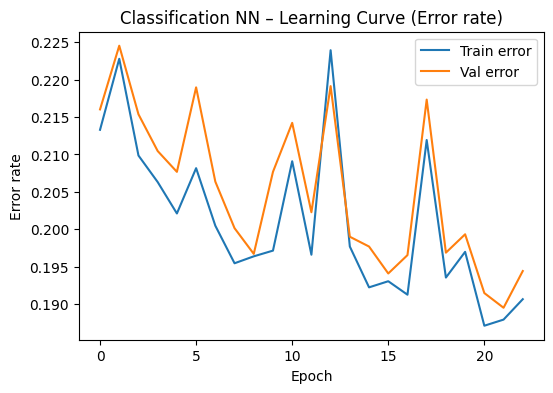

                    precision    recall  f1-score   support

    Quick (≤0.25h)       0.77      0.92      0.84      2858
   Short (0.25–3h]       0.91      0.66      0.77      2859
   Moderate (3–8h]       0.42      1.00      0.60       165
      Long (8–24h]       0.91      0.92      0.92        53
Very Long (24–50h]       0.97      0.97      0.97       153
    Extreme (>50h)       0.74      1.00      0.85        14

          accuracy                           0.80      6102
         macro avg       0.79      0.91      0.82      6102
      weighted avg       0.84      0.80      0.80      6102

[[2639  183   32    0    0    4]
 [ 769 1897  192    0    1    0]
 [   0    0  165    0    0    0]
 [   0    0    0   49    3    1]
 [   0    0    0    5  148    0]
 [   0    0    0    0    0   14]]


In [ ]:



# bin the target
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
bins = [-float('inf'), 0.25, 3, 8, 24, 50, float('inf')]
labels = [
    'Quick (≤0.25h)',
    'Short (0.25–3h]',
    'Moderate (3–8h]',
    'Long (8–24h]',
    'Very Long (24–50h]',
    'Extreme (>50h)'
]

encounters_df["ENCOUNTER_LENGTH_CLASS"] = pd.cut(
    encounters_df["DURATION_HOURS"],
    bins=bins, labels=labels,
    right=True, include_lowest=True
)

# train / test / val split & preprocessing
X_cls = encounters_df.drop(
    columns=[
        "DURATION_HOURS", "Id", "START", "PATIENTID",
        "DURATION_CAP", "ENCOUNTER_LENGTH_CLASS"
    ]
)
y_cls = encounters_df["ENCOUNTER_LENGTH_CLASS"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X_cls, y_cls, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42)

encoder_cls = CatBoostEncoder(cols=X_train.select_dtypes(
    include=['object', 'bool']).columns, random_state=42)
X_train_enc = encoder_cls.fit_transform(X_train, y_train)
X_val_enc = encoder_cls.transform(X_val)
X_test_enc = encoder_cls.transform(X_test)


scaler_cls = StandardScaler()
X_train_scaled = scaler_cls.fit_transform(X_train_enc)
X_val_scaled = scaler_cls.transform(X_val_enc)
X_test_scaled = scaler_cls.transform(X_test_enc)


# torch tensors & loaders
def to_loader(X_np, y_ser, bs=64, shuffle=False):
    Xt = torch.tensor(X_np, dtype=torch.float32)
    yt = torch.tensor(y_ser.cat.codes.values,
                      dtype=torch.long)
    return DataLoader(TensorDataset(Xt, yt), batch_size=bs, shuffle=shuffle)


train_loader_cls = to_loader(X_train_scaled, y_train, shuffle=True)
val_loader_cls = to_loader(X_val_scaled,   y_val)
test_loader_cls = to_loader(X_test_scaled,  y_test)

n_classes = len(labels)
input_dim = X_train_scaled.shape[1]

# simple classifier network (softmax)
class NNClassifier2(nn.Module):
    def __init__(self, in_dim, p_drop=0.3, n_out=n_classes):
        super().__init__()
        self.net = nn.Sequential(

            # layer 1 with starting 256 neurons and will proceed to half them each layer.
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(p_drop),

            # layer 2
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p_drop),

            # output layer
            nn.Linear(128, n_out)
        )

    def forward(self, x):  # returns logits
        return self.net(x)


clf = NNClassifier2(input_dim).to(device)

# base inverse-frequency weights
class_counts = y_train.value_counts().sort_index()  # aligned with y.cat.codes
inv_freq_weights = 1.0 / class_counts

# convert to list so we can tweak manually
w = inv_freq_weights.values

# Indices:
# 0 = Quick
# 1 = Short → increase
# 2 = Moderate → decrease
# 3 = Long
# 4 = Very Long
# 5 = Extreme

# manual tweaks
w[1] *= 1.1
w[2] *= 0.85

# normalize to keep overall loss scale stable
w = w / w.sum() * len(w)

# convert to torch tensor
class_weights = torch.tensor(w, dtype=torch.float32).to(device)

# plug into criterion
criterion_cls = nn.CrossEntropyLoss(weight=class_weights)

optim_cls = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)

# training loop + learning-curve
train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []

best_val = float('inf')
patience, wait = 10, 0

for epoch in range(1, 100):

    # train
    clf.train()
    clf.train()
    running_loss = 0.0
    total_samples = 0
    for xb, yb in train_loader_cls:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion_cls(clf(xb), yb)

        optim_cls.zero_grad()
        loss.backward()
        optim_cls.step()

        # accumulate for epoch‐level loss
        running_loss += loss.item() * yb.size(0)   # loss.item() is per‐sample average
        total_samples += yb.size(0)

    # compute average training loss
    epoch_train_loss = running_loss / total_samples
    # keeping track of the loss history
    train_loss_hist.append(epoch_train_loss)

    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        wait = 0
        torch.save(clf.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch}")
            break

    # ----- epoch-level TRAIN accuracy ---------------------------------------
    clf.eval()
    corr = tot = 0
    with torch.no_grad():
        for xb, yb in train_loader_cls:
            pred = clf(xb.to(device)).argmax(1).cpu()
            corr += (pred == yb).sum().item()
            tot += yb.size(0)
    train_acc = corr / tot
    train_acc_hist.append(train_acc)

    # ----- epoch-level VAL loss ---------------------------------------------
    clf.eval()
    running_val_loss = 0.0
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader_cls:
            xb, yb = xb.to(device), yb.to(device)
            logits = clf(xb)
            loss = criterion_cls(logits, yb)
            running_val_loss += loss.item() * yb.size(0)
            total_val += yb.size(0)

    epoch_val_loss = running_val_loss / total_val
    val_loss_hist.append(epoch_val_loss)

    # ----- epoch-level VAL accuracy -----------------------------------------
    corr = tot = 0
    with torch.no_grad():
        for xb, yb in val_loader_cls:
            pred = clf(xb.to(device)).argmax(1).cpu()
            corr += (pred == yb).sum().item()
            tot += yb.size(0)
    val_acc = corr / tot
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train loss {epoch_train_loss:.3f} | Val loss {epoch_val_loss:.3f} | "
          f"Train acc {train_acc:.3f} | Val acc {val_acc:.3f}")

# plot learning curve accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc_hist, label="Train acc")
plt.plot(val_acc_hist,   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classification NN – Learning Curve")
plt.legend()
plt.show()

# plot learning curve error rate
train_err_hist = [1.0 - acc for acc in train_acc_hist]
val_err_hist = [1.0 - acc for acc in val_acc_hist]

plt.figure(figsize=(6, 4))
plt.plot(train_err_hist, label="Train error")
plt.plot(val_err_hist,   label="Val error")
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.title("Classification NN – Learning Curve (Error rate)")
plt.legend()
plt.show()

# final classification report
def loader_preds_cls(loader):
    clf.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = clf(xb).cpu()
            all_pred.append(logits.argmax(1))
            all_true.append(yb)
    return torch.cat(all_true).numpy(), torch.cat(all_pred).numpy()


y_true, y_pred = loader_preds_cls(test_loader_cls)

print(classification_report(
    y_true, y_pred, target_names=labels, zero_division=0
))
print(confusion_matrix(y_true, y_pred))


=== Fold 1 ===
Fold 1 final → Val loss: 0.384, Val acc: 0.795

=== Fold 2 ===
Fold 2 final → Val loss: 0.253, Val acc: 0.800

=== Fold 3 ===
Fold 3 final → Val loss: 0.374, Val acc: 0.810

=== 3‑Fold CV results ===
Val loss: 0.337 ± 0.060
Val acc : 0.802 ± 0.006
Epoch 01 | Train loss 1.125 | Val loss 0.515 | Train acc 0.702 | Val acc 0.707
Epoch 02 | Train loss 0.640 | Val loss 0.433 | Train acc 0.733 | Val acc 0.736
Epoch 03 | Train loss 0.572 | Val loss 0.412 | Train acc 0.736 | Val acc 0.738
Epoch 04 | Train loss 0.526 | Val loss 0.415 | Train acc 0.735 | Val acc 0.737
Epoch 05 | Train loss 0.506 | Val loss 0.386 | Train acc 0.749 | Val acc 0.750
Epoch 06 | Train loss 0.465 | Val loss 0.396 | Train acc 0.743 | Val acc 0.743
Epoch 07 | Train loss 0.477 | Val loss 0.376 | Train acc 0.747 | Val acc 0.751
Epoch 08 | Train loss 0.439 | Val loss 0.365 | Train acc 0.762 | Val acc 0.764
Epoch 09 | Train loss 0.432 | Val loss 0.382 | Train acc 0.770 | Val acc 0.774
Epoch 10 | Train loss 0.4

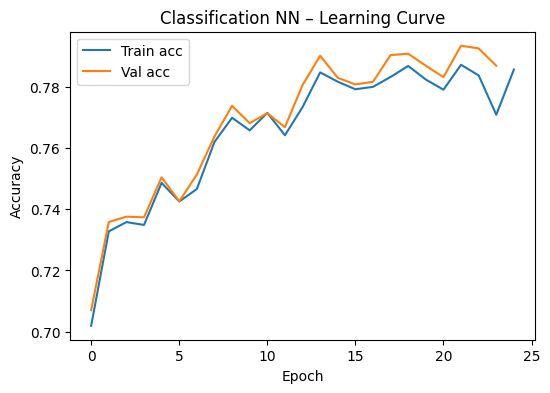

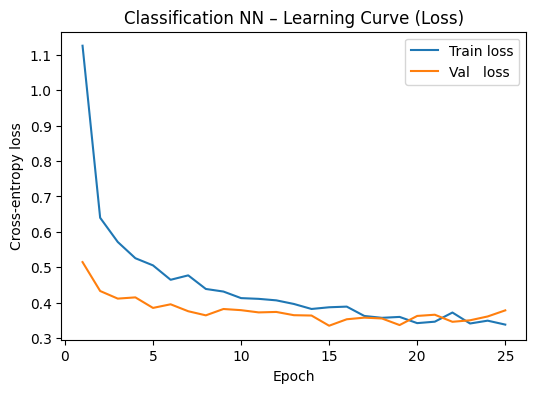

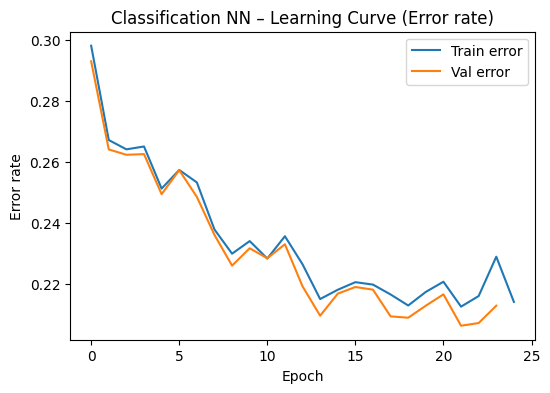

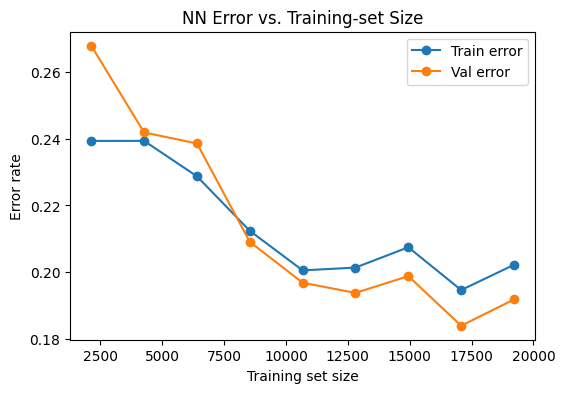

                    precision    recall  f1-score   support

    Quick (≤0.25h)       0.75      0.92      0.83      2153
   Short (0.25–3h]       0.91      0.62      0.74      2120
   Moderate (3–8h]       0.52      0.98      0.68       119
      Long (8–24h]       0.73      0.93      0.82        46
Very Long (24–50h]       0.80      0.94      0.86       125
    Extreme (>50h)       0.54      1.00      0.70        13

          accuracy                           0.79      4576
         macro avg       0.71      0.90      0.77      4576
      weighted avg       0.82      0.79      0.78      4576



In [4]:
"""
Starting new NN with different number of layers and number of nodes per layer also tried different value ranges with the bins and it lead to a 10% performance increase! - Wes
This one is the final NN with k-fold cross validation and learning curves
"""

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# binning the target
bins   = [-float('inf'), 0.25, 3, 8, 24, 50, float('inf')]
labels = [
    'Quick (≤0.25h)',
    'Short (0.25–3h]',
    'Moderate (3–8h]',
    'Long (8–24h]',
    'Very Long (24–50h]',
    'Extreme (>50h)'
]

encounters_df["ENCOUNTER_LENGTH_CLASS"] = pd.cut(
    encounters_df["DURATION_HOURS"],
    bins=bins, labels=labels,
    right=True, include_lowest=True
)


# helper to make DataLoader from numpy + pandas.Series
def to_loader(X_np, y_ser, bs=64, shuffle=False):
    Xt = torch.tensor(X_np, dtype=torch.float32)
    yt = torch.tensor(y_ser.cat.codes.values, dtype=torch.long)
    return DataLoader(TensorDataset(Xt, yt), batch_size=bs, shuffle=shuffle)


# preparing raw X, y
X_cls = encounters_df.drop(columns=[
    "DURATION_HOURS", "Id", "START", "PATIENTID",
    "DURATION_CAP", "ENCOUNTER_LENGTH_CLASS"
])
y_cls = encounters_df["ENCOUNTER_LENGTH_CLASS"].astype("category")

input_dim = X_cls.shape[1]
n_classes = len(labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# defining the NN class
class NNClassifier2(nn.Module):
    def __init__(self, in_dim, p_drop=0.35, n_out=n_classes): # used dropout regularization which is represented by p_drop=0.35
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(32, n_out)
        )
    def forward(self, x):
        return self.net(x)

# set up 3‑fold stratified cross validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_val_loss = []
cv_val_acc  = []

for fold, (train_idx, val_idx) in enumerate(
        kf.split(X_cls, y_cls.cat.codes), start=1):

    print(f"\n=== Fold {fold} ===")

    # split raw into fold‐specific train & val
    X_train_raw = X_cls.iloc[train_idx]
    y_train = y_cls.iloc[train_idx]
    X_val_raw   = X_cls.iloc[val_idx]
    y_val   = y_cls.iloc[val_idx]

    # encode high‑card cats per fold
    encoder_cls = CatBoostEncoder(
        cols=X_train_raw.select_dtypes(include=['object','bool']).columns,
        random_state=42
    )
    X_train_enc = encoder_cls.fit_transform(X_train_raw, y_train)
    X_val_enc   = encoder_cls.transform(X_val_raw)

    # scale per fold
    scaler_cls = StandardScaler()
    X_train_scaled = scaler_cls.fit_transform(X_train_enc)
    X_val_scaled   = scaler_cls.transform(X_val_enc)

    # build DataLoaders per fold
    train_loader_cls = to_loader(X_train_scaled, y_train, shuffle=True)
    val_loader_cls   = to_loader(X_val_scaled,   y_val)

    # (re)initialize model, loss, optim per fold
    clf = NNClassifier2(input_dim).to(device)
    class_counts = y_train.value_counts().sort_index()
    class_weights = torch.tensor(
        (1.0 / class_counts).values, dtype=torch.float32
    ).to(device)
    criterion_cls = nn.CrossEntropyLoss(weight=class_weights)
    optim_cls     = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)

    # train for fixed epochs on this fold
    for epoch in range(1, 75):

        # train
        clf.train()
        running, total = 0.0, 0
        for xb, yb in train_loader_cls:
            xb, yb = xb.to(device), yb.to(device)
            loss = criterion_cls(clf(xb), yb)
            optim_cls.zero_grad()
            loss.backward()
            optim_cls.step()
            running += loss.item() * yb.size(0)
            total   += yb.size(0)
        train_loss = running / total

        # validate epoch
        clf.eval()
        running, total, correct = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader_cls:
                xb, yb = xb.to(device), yb.to(device)
                logits = clf(xb)
                running += criterion_cls(logits, yb).item() * yb.size(0)
                total   += yb.size(0)
                correct += (logits.argmax(1) == yb).sum().item()
        val_loss = running / total
        val_acc  = correct / total

    print(f"Fold {fold} final → Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

    cv_val_loss.append(val_loss)
    cv_val_acc.append(val_acc)


# cross validation summary
print("\n=== 3‑Fold CV results ===")
print(f"Val loss: {np.mean(cv_val_loss):.3f} ± {np.std(cv_val_loss):.3f}")
print(f"Val acc : {np.mean(cv_val_acc) :.3f} ± {np.std(cv_val_acc) :.3f}")


# reset variables for one last train test run for plotting learning curves
X_temp, X_test, y_temp, y_test = train_test_split(
    X_cls, y_cls, test_size=0.15, random_state=42, stratify=y_cls)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

# re‑encode, rescale, rebuild DataLoaders
enc = CatBoostEncoder(cols=X_train.select_dtypes(include=['object','bool']).columns,
                      random_state=42)
sc = StandardScaler()

train_loader = to_loader(
    sc.fit_transform(enc.fit_transform(X_train, y_train)),
    y_train, shuffle=True)
val_loader = to_loader(
    sc.transform(enc.transform(X_val)),
    y_val)

# reinitialize model, criterion, optimizer
clf = NNClassifier2(input_dim).to(device)
cw = 1.0 / y_train.value_counts().sort_index()
criterion_cls = nn.CrossEntropyLoss(weight=torch.tensor(cw.values, dtype=torch.float32).to(device))
optim_cls     = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)

# run original epoch loop, repopulating lists
train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []
best_val = float('inf')
wait, patience = 0, 10
for epoch in range(1, 80):

    # train
    clf.train()
    running_loss = 0.0
    total_samples = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion_cls(clf(xb), yb)

        optim_cls.zero_grad()
        loss.backward()
        optim_cls.step()

        # accumulate for epoch‐level loss
        running_loss += loss.item() * yb.size(0)
        total_samples += yb.size(0)

    # compute average training loss
    epoch_train_loss = running_loss / total_samples

    # keeping track of the loss history
    train_loss_hist.append(epoch_train_loss)

    # ----- epoch-level TRAIN accuracy ---------------------------------------
    clf.eval()
    corr = tot = 0
    with torch.no_grad():
        for xb, yb in train_loader:
            pred = clf(xb.to(device)).argmax(1).cpu()
            corr += (pred == yb).sum().item()
            tot += yb.size(0)
    train_acc = corr / tot
    train_acc_hist.append(train_acc)

    # ----- epoch-level VAL loss ---------------------------------------------
    clf.eval()
    running_val_loss = 0.0
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = clf(xb)
            loss = criterion_cls(logits, yb)
            running_val_loss += loss.item() * yb.size(0)
            total_val += yb.size(0)

    epoch_val_loss = running_val_loss / total_val
    val_loss_hist.append(epoch_val_loss)

    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        wait = 0
        torch.save(clf.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch}")
            break

    # ----- epoch-level VAL accuracy -----------------------------------------
    corr = tot = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = clf(xb.to(device)).argmax(1).cpu()
            corr += (pred == yb).sum().item()
            tot += yb.size(0)
    val_acc = corr / tot
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train loss {epoch_train_loss:.3f} | Val loss {epoch_val_loss:.3f} | "
          f"Train acc {train_acc:.3f} | Val acc {val_acc:.3f}")

# plot learning curve accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train acc")
plt.plot(val_acc_hist,   label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Classification NN – Learning Curve"); plt.legend(); plt.show()

# Plot learning curve loss
epochs = range(1, len(train_loss_hist) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss_hist, label="Train loss")
plt.plot(epochs,   val_loss_hist,   label="Val   loss")
plt.xlabel("Epoch")
plt.ylabel("Cross‑entropy loss")
plt.title("Classification NN – Learning Curve (Loss)")
plt.legend()
plt.show()

# plot learning curve error rate
train_err_hist = [1.0 - acc for acc in train_acc_hist]
val_err_hist   = [1.0 - acc for acc in val_acc_hist]

plt.figure(figsize=(6,4))
plt.plot(train_err_hist, label="Train error")
plt.plot(val_err_hist,   label="Val error")
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.title("Classification NN – Learning Curve (Error rate)")
plt.legend()
plt.show()


#  Sample‑size learning curve for the NN
# ---------------------------------------

# prepare arrays to record error vs. training‐set size
fractions = np.linspace(0.1, 0.9, 9)
train_errs = []
val_errs   = []

for frac in fractions:

    # subsample the training data
    X_sub, _, y_sub, _ = train_test_split(
        X_train, y_train,
        train_size=frac,
        stratify=y_train,
        random_state=42
    )

    # re‑encode & rescale on the subset
    enc = CatBoostEncoder(
        cols=X_sub.select_dtypes(include=['object','bool']).columns,
        random_state=42
    )
    sc = StandardScaler()
    X_sub_enc = sc.fit_transform(enc.fit_transform(X_sub, y_sub))
    X_val_enc = sc.transform(enc.transform(X_val))

    # init & train a fresh model on that subset
    model = NNClassifier2(input_dim).to(device)
    cw = 1.0 / y_sub.value_counts().sort_index()
    crit = nn.CrossEntropyLoss(weight=torch.tensor(cw.values, dtype=torch.float32).to(device))
    opt  = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # train until convergence or fixed epochs
    for epoch in range(80):
        model.train()
        for xb, yb in to_loader(X_sub_enc, y_sub, shuffle=True):
            xb, yb = xb.to(device), yb.to(device)
            loss = crit(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()

    # evaluate final error on train‐subset and on X_val
    model.eval()
    correct, total = 0, 0
    for xb, yb in to_loader(X_sub_enc, y_sub):
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        correct += (preds == yb).sum().item(); total += yb.size(0)
    train_errs.append(1 - correct/total)

    correct, total = 0, 0
    for xb, yb in to_loader(X_val_enc, y_val):
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        correct += (preds == yb).sum().item(); total += yb.size(0)
    val_errs.append(1 - correct/total)

# plot error vs. actual training‐set size
sizes = fractions * len(X_train)
plt.figure(figsize=(6,4))
plt.plot(sizes, train_errs, marker='o', label="Train error")
plt.plot(sizes, val_errs,   marker='o', label="Val error")
plt.xlabel("Training set size")
plt.ylabel("Error rate")
plt.title("NN Error vs. Training‐set Size")
plt.legend()
plt.show()


#  Final classification report on training and validation set combined
# ---------------------------------------------------------------------
from sklearn.metrics import classification_report

def loader_preds_cls(loader):
    clf.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = clf(xb).cpu()
            all_pred.append(logits.argmax(1))
            all_true.append(yb)
    return torch.cat(all_true).numpy(), torch.cat(all_pred).numpy()

# combine train + val
X_full_raw = pd.concat([X_train, X_val], axis=0)
y_full      = pd.concat([y_train, y_val], axis=0)

# re-encode, rescale on the combined set
enc_full = CatBoostEncoder(
    cols=X_full_raw.select_dtypes(include=['object','bool']).columns,
    random_state=42)
X_full_enc   = enc_full.fit_transform(X_full_raw, y_full)
X_test_enc   = enc_full.transform(X_test)

sc_full = StandardScaler()
X_full_scaled = sc_full.fit_transform(X_full_enc)
X_test_scaled = sc_full.transform(X_test_enc)

# dataLoaders
train_loader_full = to_loader(X_full_scaled, y_full, shuffle=True)
test_loader_cls   = to_loader(X_test_scaled, y_test)

# final model fit & test
clf_final = NNClassifier2(input_dim).to(device)
cw_full = 1.0 / y_full.value_counts().sort_index()
criterion_final = nn.CrossEntropyLoss(weight=torch.tensor(cw_full.values, dtype=torch.float32).to(device))
optim_final    = optim.Adam(clf_final.parameters(), lr=1e-3, weight_decay=1e-4)

# final training with test set
for epoch in range(1, 80):
    clf_final.train()
    running_loss = 0.0
    total_samples = 0
    for xb, yb in train_loader_full:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion_final(clf_final(xb), yb)

        optim_final.zero_grad()
        loss.backward()
        optim_final.step()

        # accumulate for epoch‐level loss
        running_loss += loss.item() * yb.size(0)
        total_samples += yb.size(0)

    # compute average training loss
    epoch_train_loss = running_loss / total_samples

    # keeping track of the loss history
    train_loss_hist.append(epoch_train_loss)


# evaluate on test
y_true, y_pred = loader_preds_cls(test_loader_cls)
print(classification_report(y_true, y_pred, target_names=labels))